In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg19_pretrained/pytorch/pretrained/1/vgg19-dcbb9e9d (1).pth
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3607).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3961).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3958).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3643).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(4088).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3679).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3506).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(4161).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(4121).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3534).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3596).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3460).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3741).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/PNEUMONIA(3819).jpg
/kaggle/input/covid-19/test/test/PNEUMONIA/

In [18]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
def resize_and_normalize_images(data_directory, label_value):
    images = []
    labels = []

    for image in tqdm(os.listdir(data_directory)):
        file_path = os.path.join(data_directory, image)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            img = img / 255.0
            images.append(img)
            labels.append(label_value)

    return images, labels


In [5]:
train_covid_images, train_covid_labels = resize_and_normalize_images('/kaggle/input/covid-19/train/train/COVID19', 0)
train_normal_images, train_normal_labels = resize_and_normalize_images('/kaggle/input/covid-19/train/train/NORMAL', 1)
train_pneumonia_images, train_pneumonia_labels = resize_and_normalize_images('/kaggle/input/covid-19/train/train/PNEUMONIA', 2)

100%|██████████| 3418/3418 [00:46<00:00, 74.28it/s]


In [6]:
test_covid_images, test_covid_labels = resize_and_normalize_images('/kaggle/input/covid-19/test/test/COVID19', 0)
test_normal_images, test_normal_labels = resize_and_normalize_images('/kaggle/input/covid-19/test/test/NORMAL', 1)
test_pneumonia_images, test_pneumonia_labels = resize_and_normalize_images('/kaggle/input/covid-19/test/test/PNEUMONIA', 2)

100%|██████████| 855/855 [00:10<00:00, 77.93it/s]


Text(0.5, 1.0, 'Pneumonia')

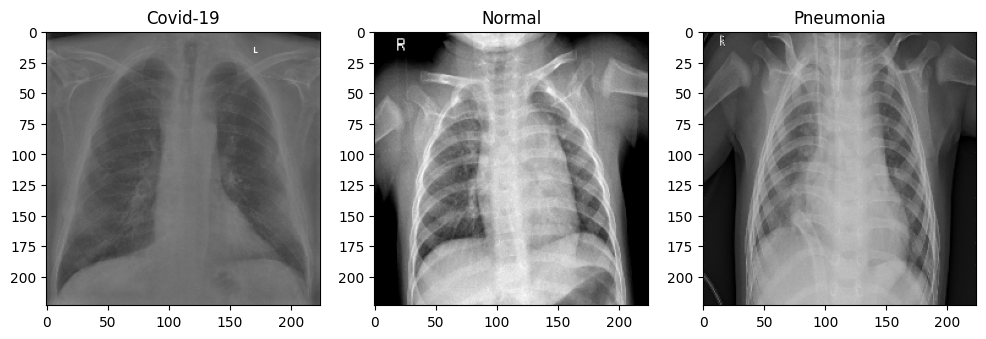

In [7]:
fig, ax = plt.subplots(1, 3, figsize = (12, 8))

ax[0].imshow(train_covid_images[0])
ax[0].set_title("Covid-19")

ax[1].imshow(train_normal_images[0])
ax[1].set_title("Normal")

ax[2].imshow(train_pneumonia_images[0])
ax[2].set_title("Pneumonia")

Text(0.5, 1.0, 'Pneumonia')

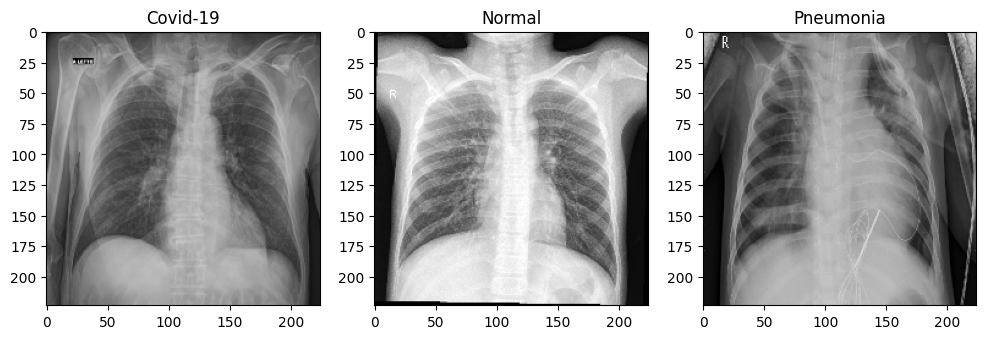

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (12, 8))

ax[0].imshow(test_covid_images[0])
ax[0].set_title("Covid-19")

ax[1].imshow(test_normal_images[0])
ax[1].set_title("Normal")

ax[2].imshow(test_pneumonia_images[0])
ax[2].set_title("Pneumonia")

In [9]:
X_train = np.concatenate((train_covid_images, train_normal_images, train_pneumonia_images))
y_train = np.concatenate((train_covid_labels, train_normal_labels, train_pneumonia_labels))

X_test = np.concatenate((test_covid_images, test_normal_images, test_pneumonia_images))
y_test = np.concatenate((test_covid_labels, test_normal_labels, test_pneumonia_labels))


In [10]:
X_train.shape

(5144, 224, 224, 3)

In [11]:
y_train.shape

(5144,)

In [12]:
X_test.shape

(1288, 224, 224, 3)

In [13]:
y_test.shape

(1288,)

In [55]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(3, activation = "softmax"))

opt = keras.optimizers.Adam(0.0001)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) 
model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     4,817,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,977,283 (18.99 MB)

 Trainable params: 4,977,283 (18.99 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint('model/best.keras', monitor='accuracy', verbose=1, mode='max', save_best_only=True)
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=64, 
    validation_split=0.2, 
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6183 - loss: 0.8346
Epoch 1: accuracy improved from -inf to 0.71932, saving model to model/best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.6199 - loss: 0.8319 - val_accuracy: 0.9320 - val_loss: 0.1895
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9049 - loss: 0.2740
Epoch 2: accuracy improved from 0.71932 to 0.91349, saving model to model/best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.9050 - loss: 0.2736 - val_accuracy: 0.9747 - val_loss: 0.0899
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9231 - loss: 0.2157
Epoch 3: accuracy improved from 0.91349 to 0.92637, saving model to model/best.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.9231 - loss: 0.2156 - val_accuracy: 0.9835 - val_loss: 0.0537
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9372 - loss: 0.1834
Epoch 4: accuracy improved from 0.92637 to 0.93536, saving model to 

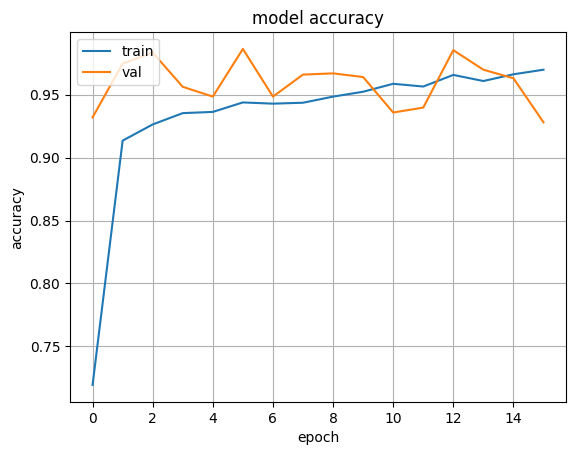

In [57]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.grid()
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()


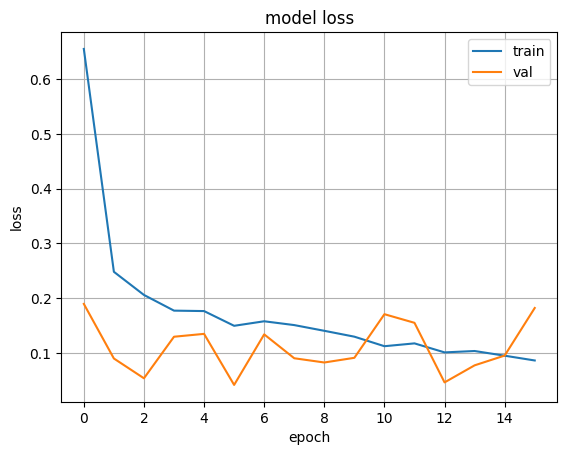

In [58]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

In [59]:
train_result = model.evaluate(X_train, y_train)
test_result = model.evaluate(X_test, y_test)
df = pd.DataFrame({'Train': train_result, 'Test': test_result}, index=['Loss', 'Accuracy'])
print(df)


161/161 ━━━━━━━━━━━━━━━━━━━━ 99s 607ms/step - accuracy: 0.9773 - loss: 0.0692
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 558ms/step - accuracy: 0.9511 - loss: 0.1440
             Train      Test
Loss      0.105528  0.189374
Accuracy  0.960537  0.936335


41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 560ms/step
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97       116
   Pneumonia       0.82      0.97      0.89       317
       Covid       0.99      0.92      0.95       855

    accuracy                           0.94      1288
   macro avg       0.93      0.95      0.94      1288
weighted avg       0.94      0.94      0.94      1288



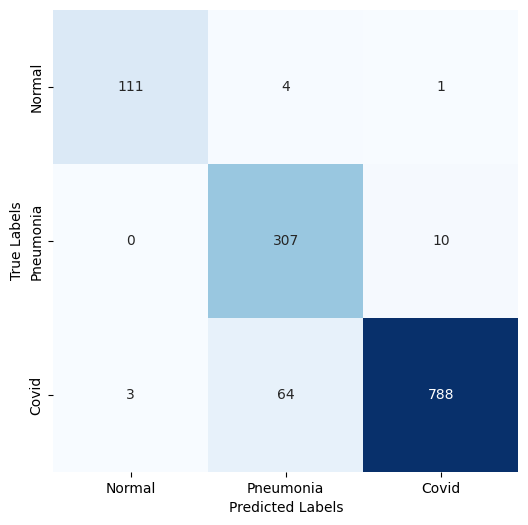

In [60]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred)
hm = sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,
                 xticklabels=['Normal', 'Pneumonia', 'Covid'],
                 yticklabels=['Normal', 'Pneumonia', 'Covid'])
hm.set(xlabel='Predicted Labels', ylabel='True Labels')

print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia', 'Covid']))


In [61]:
model.save('model/cnn2.h5')

In [30]:
covid_images = '/kaggle/input/images/images/covid'
normal_images = '/kaggle/input/images/images/normal/'
pneumonia_images = '/kaggle/input/images/images/pneumonie/'

In [31]:
print("Number of COVID19 images:", len(os.listdir(covid_images)))
print("Number of Normal images:", len(os.listdir(normal_images)))
print("Number of Pneumonia images:", len(os.listdir(pneumonia_images)))

Number of COVID19 images: 4
Number of Normal images: 3
Number of Pneumonia images: 3


In [32]:
covid_images, covid_labels = resize_and_normalize_images(covid_images, 0)
normal_images, normal_labels = resize_and_normalize_images(normal_images, 1)
pneumonia_images,pneumonia_labels = resize_and_normalize_images(pneumonia_images, 2)

100%|██████████| 3/3 [00:00<00:00, 77.77it/s]


In [64]:
X_test_images = np.concatenate((covid_images, normal_images, pneumonia_images))
y_test_lables = np.concatenate((covid_labels, normal_labels, pneumonia_labels))


In [65]:
model.predict(X_test_images[0:1]).argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([0])

In [67]:
results= []
for i in range(10):
    image = X_test_images[i:i+1]
    expected_label = y_test_lables[i]
    pred = model.predict(image).argmax(axis=1)[0]
    results.append((f'image{i+1}', pred, expected_label))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [68]:
print("Résultats ")
for result in results:
    print(f"{result[0]} / Prédiction: {result[1]} / Résultats attendus: {result[2]}")


Résultats 
image1 / Prédiction: 0 / Résultats attendus: 0
image2 / Prédiction: 0 / Résultats attendus: 0
image3 / Prédiction: 0 / Résultats attendus: 0
image4 / Prédiction: 0 / Résultats attendus: 0
image5 / Prédiction: 1 / Résultats attendus: 1
image6 / Prédiction: 1 / Résultats attendus: 1
image7 / Prédiction: 1 / Résultats attendus: 1
image8 / Prédiction: 2 / Résultats attendus: 2
image9 / Prédiction: 2 / Résultats attendus: 2
image10 / Prédiction: 1 / Résultats attendus: 2


In [70]:
model.evaluate(X_test_images,y_test_lables)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9000 - loss: 0.1503


[0.1502944827079773, 0.8999999761581421]